# Reading the weather and ebird combined dataset by PySpark

In [1]:
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import substring


spark = SparkSession.builder.appName('weather_ebird_etl').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext


schema = types.StructType([
            types.StructField("speciesCode",types.StringType()),
            types.StructField("comName",types.StringType()),
            types.StructField("sciName",types.StringType()),
            types.StructField("locId",types.StringType()),
            types.StructField("locName",types.StringType()),
            types.StructField("obsDt",types.DateType()),
            types.StructField("howMany",types.IntegerType()),
            types.StructField("lat",types.FloatType()),
            types.StructField("lng",types.FloatType()),
            types.StructField("ebird_id",types.StringType()),


            types.StructField('station_id', types.StringType()),
            types.StructField('date', types.StringType()),
            types.StructField('PRCP', types.FloatType()),
            types.StructField('SNOW', types.FloatType()),
            types.StructField('SNWD', types.FloatType()),
            types.StructField('TMIN', types.FloatType()),
            types.StructField('TMAX', types.FloatType()),
            types.StructField("Latitude", types.FloatType()),
            types.StructField("Longitude", types.FloatType()),
            types.StructField("Elevation", types.FloatType()),
            types.StructField("State", types.StringType()),])


weather_ebird_df = spark.read.format('csv').schema(schema).option("header","true").load("gs://big-data-1-project-storage/cleaned-data/joined-data-final")
finalsaver = weather_ebird_df.filter( weather_ebird_df['lat'].isNotNull())
df = finalsaver.withColumn('year', substring('obsDt', 1,4))\
    .withColumn('month', substring('obsDt', 6,2))\
    .withColumn('day', substring('obsDt', 9,2))

In [2]:
df = df.drop('all')

Filtering the dataset for the year 2022 by reomving rows.

In [3]:
from pyspark.sql.types import IntegerType

df = df.select(df.comName,df.howMany,df.year,df.month,df.day,df.TMIN,df.TMAX,df.SNOW,df.PRCP)

df = df.withColumn("year", df["year"].cast(IntegerType())).withColumn("TMAX", df["TMAX"].cast(IntegerType())).withColumn("TMIN", df["TMIN"].cast(IntegerType()))\
.withColumn("SNOW", df["SNOW"].cast(IntegerType())).withColumn("PRCP", df["PRCP"].cast(IntegerType()))

df=df.filter(df.year != 2022)

In [4]:
from pyspark.sql import functions as F

df=df.withColumn('decade', F.when( (F.col("year") >= 1958) & (F.col("year") <= 1970), '1958-1970').
    when( (F.col("year") >= 1971) & (F.col("year") <= 1980), '1971-1980').
    when( (F.col("year") >= 1981) & (F.col("year") <= 1990), '1981-1990').
    when( (F.col("year") >= 1991) & (F.col("year") <= 2000), '1991-2000').
    when( (F.col("year") >= 2001) & (F.col("year") <= 2010), '2001-2010').    
    when( (F.col("year") >= 2011) & (F.col("year") <= 2021), '2011-2021'))

In [5]:
copy_df = df

# Working with TMAX

Keep the temperature between 0 and 50 only. The dataset had minimum temperature as 0 so filtering according to that and picking the max as 50

In [6]:
df = df[(df['TMAX'] >= 0) & (df['TMAX'] <=50)]

Creating bins of 10 for Temperature range

In [7]:
df=df.withColumn('temp_range', F.when( (F.col("TMAX") >= 0) & (F.col("TMAX") <= 10), '0-10').
    when( (F.col("TMAX") >= 11) & (F.col("TMAX") <= 20), '11-20').
    when( (F.col("TMAX") >= 21) & (F.col("TMAX") <= 30), '21-30').
    when( (F.col("TMAX") >= 31) & (F.col("TMAX") <= 40), '31-40').
    when( (F.col("TMAX") >= 41) & (F.col("TMAX") <= 50), '41-50'))

In [8]:
temp = df.select(df.temp_range,df.howMany)

In [9]:
import pandas as pd
import numpy as np

temp_df = temp.toPandas()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,10)})

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
count_tmax = temp_df.groupby(["temp_range"]).howMany.sum().reset_index()

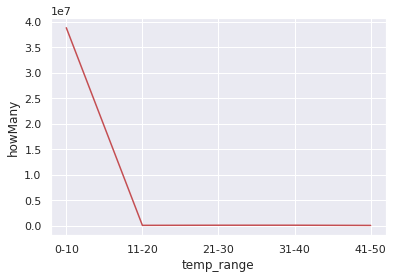

In [12]:
sns.lineplot(x = 'temp_range',y='howMany', data = count_tmax, color = 'r')

# WORKING WITH SNOW

In [13]:
df = copy_df

Filtering the dataset for any negative values and the max was 27 so filtering the maximum value upto 27

In [14]:
df = df[(df['SNOW'] >= 0) & (df['SNOW'] <=27)]

df=df.withColumn('snow_range', F.when( (F.col("SNOW") >= 0) & (F.col("SNOW") <= 9), '0-9').
    when( (F.col("SNOW") >= 10) & (F.col("SNOW") <= 18), '10-18').
    when( (F.col("SNOW") >= 19) & (F.col("SNOW") <= 27), '21-30'))

In [15]:
snow = df.select(df.snow_range,df.howMany)

In [16]:
snow.groupBy('snow_range').count().orderBy('count').show(10)

+----------+------+
|snow_range| count|
+----------+------+
|     21-30|  6753|
|     10-18|343349|
|       0-9|636750|
+----------+------+



In [17]:
snow_df = snow.toPandas()

In [18]:
snow_count = snow_df.groupby(["snow_range"]).howMany.sum().reset_index()

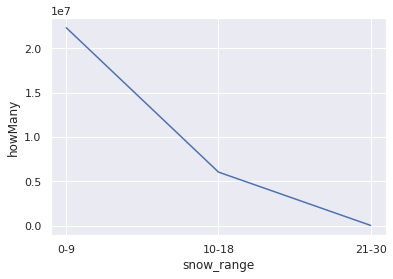

In [19]:
sns.lineplot(x = 'snow_range',y='howMany', data = snow_count, color = 'b')

# WORKING WITH RAIN

In [20]:
df = copy_df

Filtering the precipitation as the minimum is 0 and the maximum showed was 47

In [21]:
df = df[(df['PRCP'] >= 0) & (df['PRCP'] <=47)]

df=df.withColumn('prcp_range', F.when( (F.col("PRCP") >= 0) & (F.col("PRCP") <= 12), '0-12').
    when( (F.col("PRCP") >= 13) & (F.col("PRCP") <= 24), '13-24').
    when( (F.col("PRCP") >= 25) & (F.col("PRCP") <= 36), '25-36').
    when( (F.col("PRCP") >= 37) & (F.col("PRCP") <= 47), '37-47'))

In [22]:
prcp = df.select(df.prcp_range,df.howMany)

In [23]:
prcp.groupBy('prcp_range').count().orderBy('count').show(10)

+----------+------+
|prcp_range| count|
+----------+------+
|     37-47|  3210|
|     25-36|185984|
|      0-12|390104|
|     13-24|548633|
+----------+------+



In [24]:
prcp_df = prcp.toPandas()

In [25]:
prcp_count = prcp_df.groupby(["prcp_range"]).howMany.sum().reset_index()

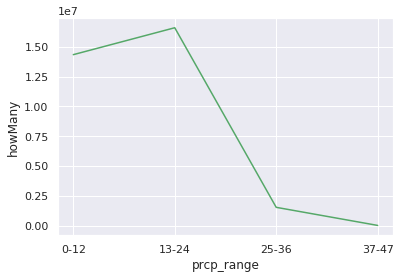

In [26]:
sns.lineplot(x='prcp_range' , y='howMany', data = prcp_count, color = 'g')

# Correlation

In [61]:
corr_df = copy_df.toPandas()

In [73]:
corr_df = corr_df[(corr_df['TMAX'] >= 0) & (corr_df['TMAX'] <=50)]
corr_df = corr_df[(corr_df['SNOW'] >= 0) & (corr_df['SNOW'] <=27)]
corr_df = corr_df[(corr_df['PRCP'] >= 0) & (corr_df['PRCP'] <=47)]

In [74]:
dataframe = corr_df.groupby(["year","comName","SNOW","TMAX","PRCP"]).howMany.sum().reset_index()
#dataframe.drop(['year'],axis = 'columns',inplace = True)

In [75]:
dataframe.corr()

,year,SNOW,TMAX,PRCP,howMany
year,1.000000,0.089634,0.005892,0.075067,-0.004834
SNOW,0.089634,1.000000,-0.119981,0.670847,-0.008532
TMAX,0.005892,-0.119981,1.000000,-0.136606,-0.001437
PRCP,0.075067,0.670847,-0.136606,1.000000,-0.022041
howMany,-0.004834,-0.008532,-0.001437,-0.022041,1.000000


(5.0, 0.0)

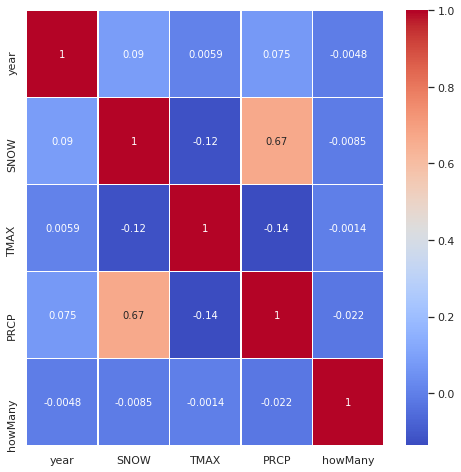

In [78]:
import seaborn as sns
df_corr = dataframe.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(df_corr, annot=True, linewidth=0.5, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)